<a href="https://colab.research.google.com/github/doeungim/ADP_DE2/blob/main/ADP_34_PRAC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [152]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import r2_score, mean_absolute_error, f1_score, accuracy_score


from scipy.stats import chi2_contingency

In [153]:
df = pd.read_csv('https://raw.githubusercontent.com/doeungim/ADP_DE2/refs/heads/main/dataset/vlbw.csv')
df.head()
df = df.iloc[:,1:]

#### 1-1) 뇌출혈 크로스탭 / 분할표
##### pvh,ivh,ipe 컬럼들간의 분할표를 생성하고 관계를 통계검정.

In [154]:
lst = [('pvh','ivh') , ('pvh','ipe'), ('ivh','ipe')]
res =[]
for v1, v2 in lst :
  cross = pd.crosstab(df[v1], df[v2])
  stat, p_val , _, _  = chi2_contingency(cross)
  print(cross)
  decision = '유희하다' if p_val < 0.05 else '유의하지않다'
  res.append({
      'var1' : v1,
      'var2' : v2,
      'p_value' : p_val,
      'decision' : decision
  })


print(pd.DataFrame(res))

ivh       absent  definite  possible
pvh                                 
absent       321        34         5
definite      81        39         5
possible      39         2         0
ipe       absent  definite  possible
pvh                                 
absent       330        20        10
definite     105        15         4
possible      35         3         3
ipe       absent  definite  possible
ivh                                 
absent       412        16        14
definite      50        21         3
possible       9         1         0
  var1 var2       p_value decision
0  pvh  ivh  4.049839e-09     유희하다
1  pvh  ipe  7.848100e-02   유의하지않다
2  ivh  ipe  4.632591e-12     유희하다


##### 1-2) Bleed (세 컬럼 모두 absent면 0, 셋 중 하나라도 positive or definite 이면 1, 나머지 na)  
- pvh,ivh,ipe	 컬럼으로 생성 // 0,1분포
- Ind (pvh,ivh,ipe 제외한 모든컬럼이 결측치 없으먼 0, bleed가 결측이면 1, 나머지는 2)

In [155]:
# np.where
#np.where(df['pvh', 'ivh' ,'ipe'])
df['Bleed'] =  np.where(
                        (df[['pvh', 'ivh' ,'ipe']] == 'absent').all(axis =1), 0 ,
                                  np.where(
                                      (df[['pvh', 'ivh' ,'ipe']].isin(['positive','definite'])).any(axis =1) , 1 ,
                                      np.nan
                                  )
                        )

```python
def bleed(x) :
  pvh = x['pvh']
  ivh = x['ivh']
  ipe = x['ipe']

  if pvh == 'absent' and ivh == 'absent' and ipe == 'absent' :
    return 0
  elif pvh in ['positive','definite'] or ivh in ['positive','definite'] or ipe in ['positive','definite'] :
    return 1
  else :
    return np.nan

def change_bleed(x) :
  if all(val == 'absent' for val in [x['pvh'], x['ivh'], x['ipe']]) :
    return 0
  elif any(val in ['positive','definite'] for val in [x['pvh'], x['ivh'], x['ipe']]) :
    return 1
  else :
    np.nan  


```

In [156]:
## Ind - 풀이1)
df['Ind'] = np.where(
    df.drop(columns = ['pvh','ivh','ipe']).isna().sum(axis =1) == 0, 0 ,
    np.where(
        (df['Bleed']).isna() , 1, 2
))

df['Ind'].value_counts()

,count
Ind,
2,326
1,193
0,152


In [157]:
## Ind - 풀이2)
def ind(x) :
  if x.drop(columns = ['pvh','ivh','ipe']).isnull().sum() == 0 :
    return 0
  elif pd.isna(x['Bleed']) :
    return 1
  else :
    return 2

df.apply(ind, axis = 1).value_counts()

,count
2,326
1,193
0,152


##### 1-3) 변수별 결측치 처리(pvh,ivh,ipe는 제외하고) 전처리


In [158]:
display(df[target_cols].isna().sum().to_frame().T)
print('''
분포를 기반으로, 범주형은 최빈값으로, 수치형은 대칭 분포 기준으로 왜도가 0.5이하이면 대칭적인 분포이기 때문에,
평균값으로 대체하고, 한쪽으로 치우친 데이터의 경우는 중앙값으로 대체한다.
''')

,Bleed,Ind,apg1,birth,bwt,cld,dead,delivery,exit,gest,...,meth,pda,pltct,pneumo,race,sex,toc,twn,vent,year
0,193,0,34,21,2,66,0,22,31,4,...,106,29,70,26,25,21,106,20,30,21



분포를 기반으로, 범주형은 최빈값으로, 수치형은 대칭 분포 기준으로 왜도가 0.5이하이면 대칭적인 분포이기 때문에,
평균값으로 대체하고, 한쪽으로 치우친 데이터의 경우는 중앙값으로 대체한다.



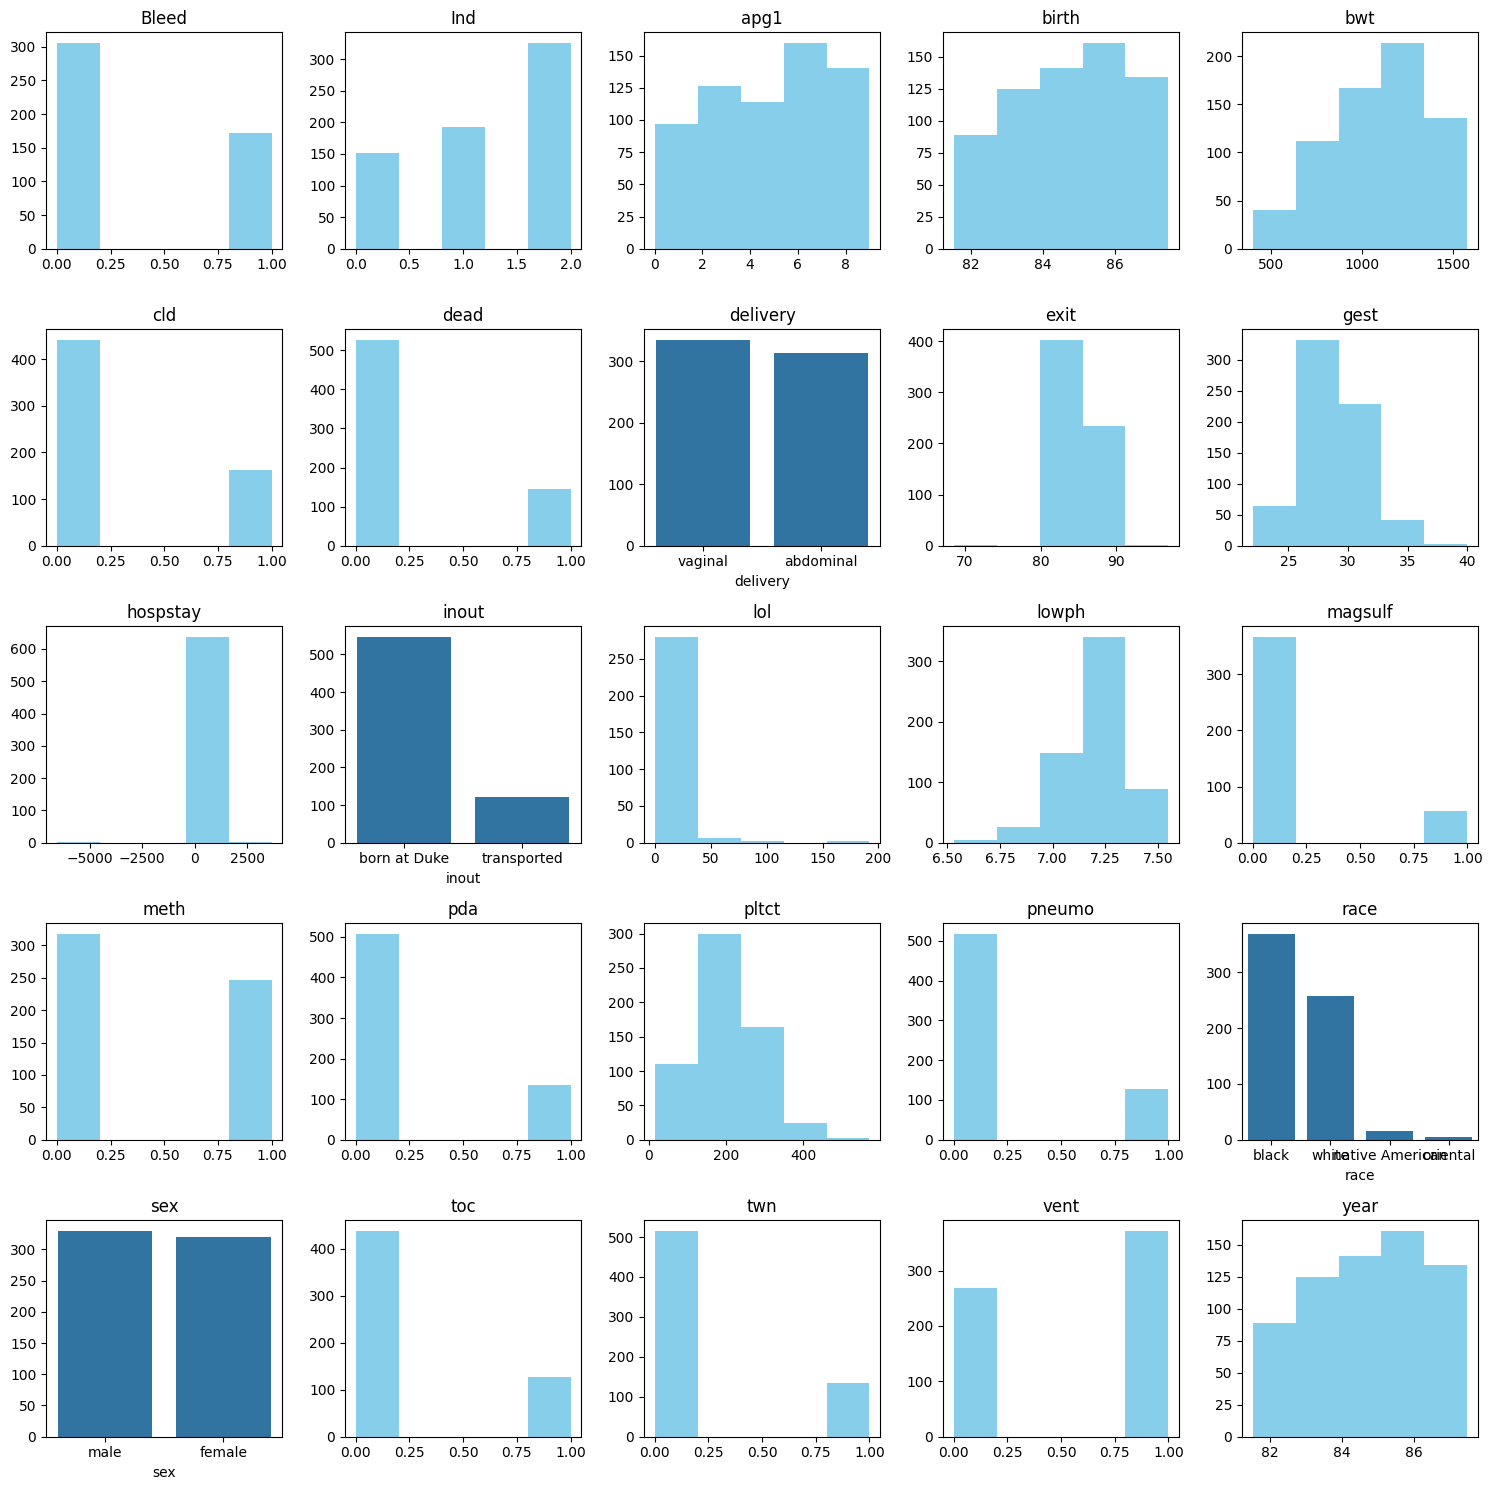

In [159]:
exclude_col = ['pvh','ivh','ipe']
target_cols =  df.columns.difference(exclude_col)


# 결측 처리를 위한 확인
fig, axes = plt.subplots(5, 5, figsize=(15, 15))

for ax, col in zip(axes.flatten(), target_cols):
  if df[col].dtypes == 'object':
    target = df[col].value_counts()
    sns.barplot(x=target.index, y=target.values, ax=ax)
    ax.set_title(col)
  else:
    ax.hist(df[col].dropna(), bins=5, color='skyblue')
    ax.set_title(col)

plt.tight_layout()
plt.show()

In [160]:
# 결측처리하기
c_df = df.copy()
exclude_col = ['pvh','ivh','ipe']
target_cols =  c_df.columns.difference(exclude_col)

for col in target_cols :
  if c_df[col].isnull().sum() > 0 :
    if c_df[col].dtype == 'object' :
      c_df[col] = c_df[col].fillna(c_df[col].mode()[0])

    else :
      if c_df[col].skew() < 0.5 :
        c_df[col] = c_df[col].fillna(c_df[col].mean())
      else :
        c_df[col] = c_df[col].fillna(c_df[col].median())


display(c_df.isna().sum().to_frame().T)

,birth,exit,hospstay,lowph,pltct,race,bwt,gest,inout,twn,...,pda,cld,pvh,ivh,ipe,year,sex,dead,Bleed,Ind
0,0,0,0,0,0,0,0,0,0,0,...,0,0,145,144,144,0,0,0,0,0


In [161]:
pre_df = c_df.drop(columns = ['pvh','ivh','ipe'], axis = 1)


In [162]:
## 데이터모델 학습을 위한 전처리

m_df = pd.DataFrame()
for col in pre_df.columns :
  if col in ['Bleed' ,'Ind','dead'] :
    m_df[col] = pre_df[col]

  elif pre_df[col].dtype == 'object' :
    dummies = pd.get_dummies(pre_df[col], prefix = col, dtype = int)
    for d_col in dummies.columns :
      m_df[d_col] = dummies[d_col]

  else :
    ss = StandardScaler()
    m_df[col] = ss.fit_transform(pre_df[[col]]).flatten()

m_df.head()

,birth,exit,hospstay,lowph,pltct,race_black,race_native American,race_oriental,race_white,bwt,...,vent,pneumo,pda,cld,year,sex_female,sex_male,dead,Bleed,Ind
0,-2.059550,-1.850831,-0.021367,0.000000,-1.334146,0,0,0,1,0.589929,...,-1.203172,-0.483173,-0.499534,-0.56645,-2.060001,1,0,0,0.0,1
1,-2.057645,-1.887960,-0.105405,0.352818,0.556478,0,0,0,1,1.043390,...,-1.203172,-0.483173,-0.499534,-0.56645,-2.058255,1,0,0,0.0,1
2,-2.033517,-1.880534,-0.142382,-1.040948,-1.150335,1,0,0,0,-1.790743,...,0.870035,-0.483173,-0.499534,-0.56645,-2.033917,1,0,1,0.0,1
3,-2.029707,-1.814844,-0.001198,0.352818,-0.257540,1,0,0,0,1.459063,...,-1.203172,-0.483173,-0.499534,-0.56645,-2.030469,0,1,0,0.0,1
4,-2.007484,-1.853687,-0.128936,-1.701153,-1.938095,1,0,0,0,-0.638195,...,0.870035,2.069653,-0.499534,-0.56645,-2.007871,1,0,1,1.0,2


##### 1-4) 모델 분석을 위한 EDA


<Axes: >

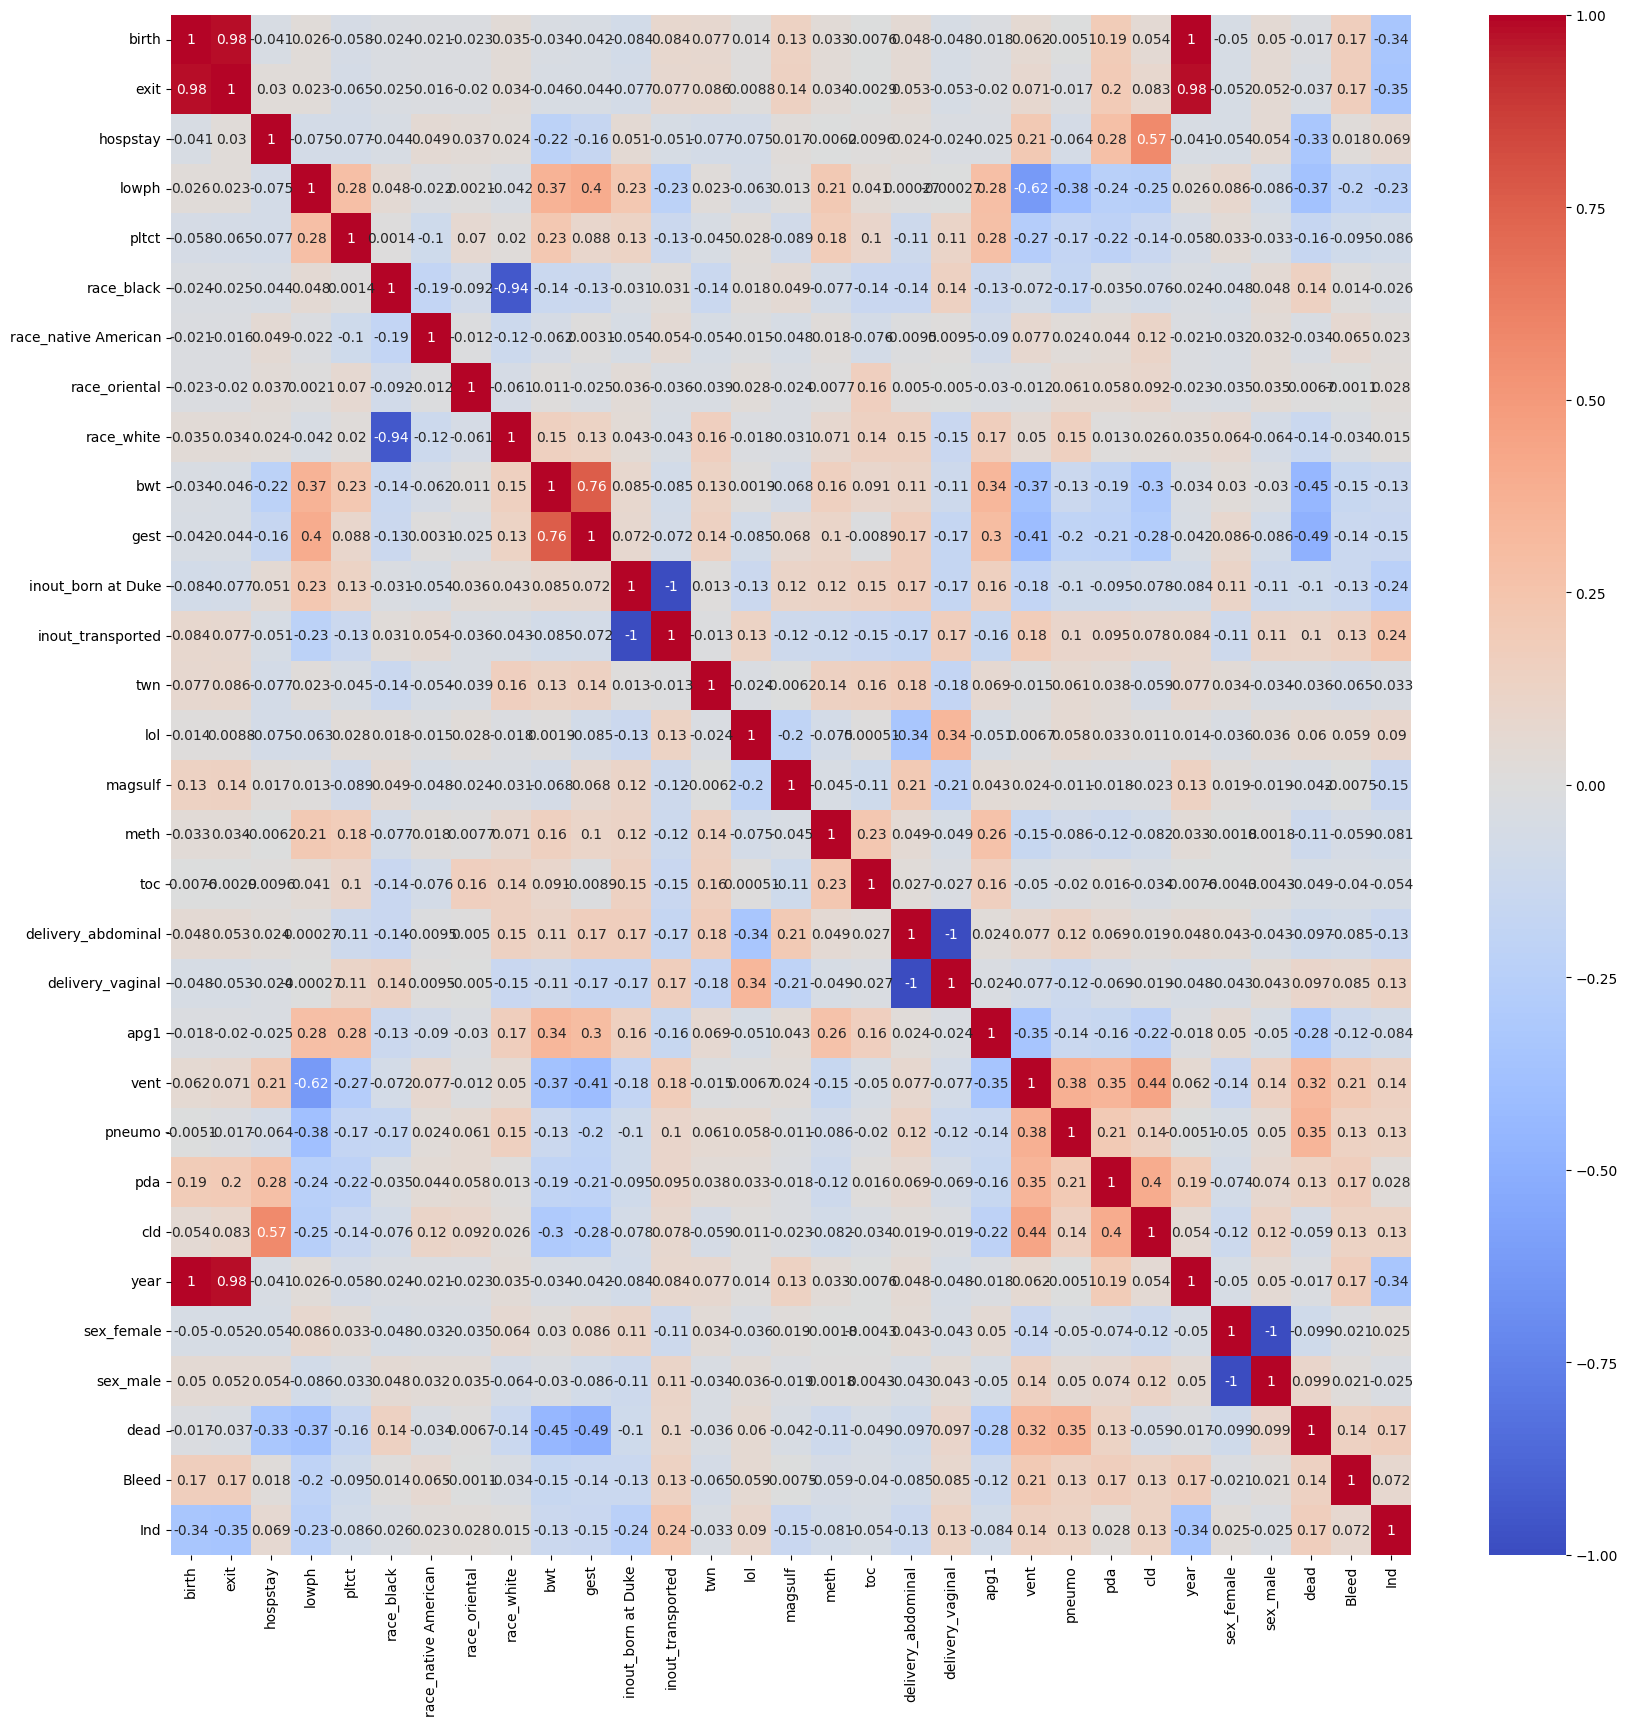

In [163]:
# 1. 상관분석 - 스피어만
# 순위 비교를 함으로 이진 변수 (0/1)와도 안정적으로 비교 가능

cor = m_df.corr(method = 'spearman')
plt.figure(figsize = (20, 20))
sns.heatmap(cor, annot = True, cmap = 'coolwarm' , center = 0)


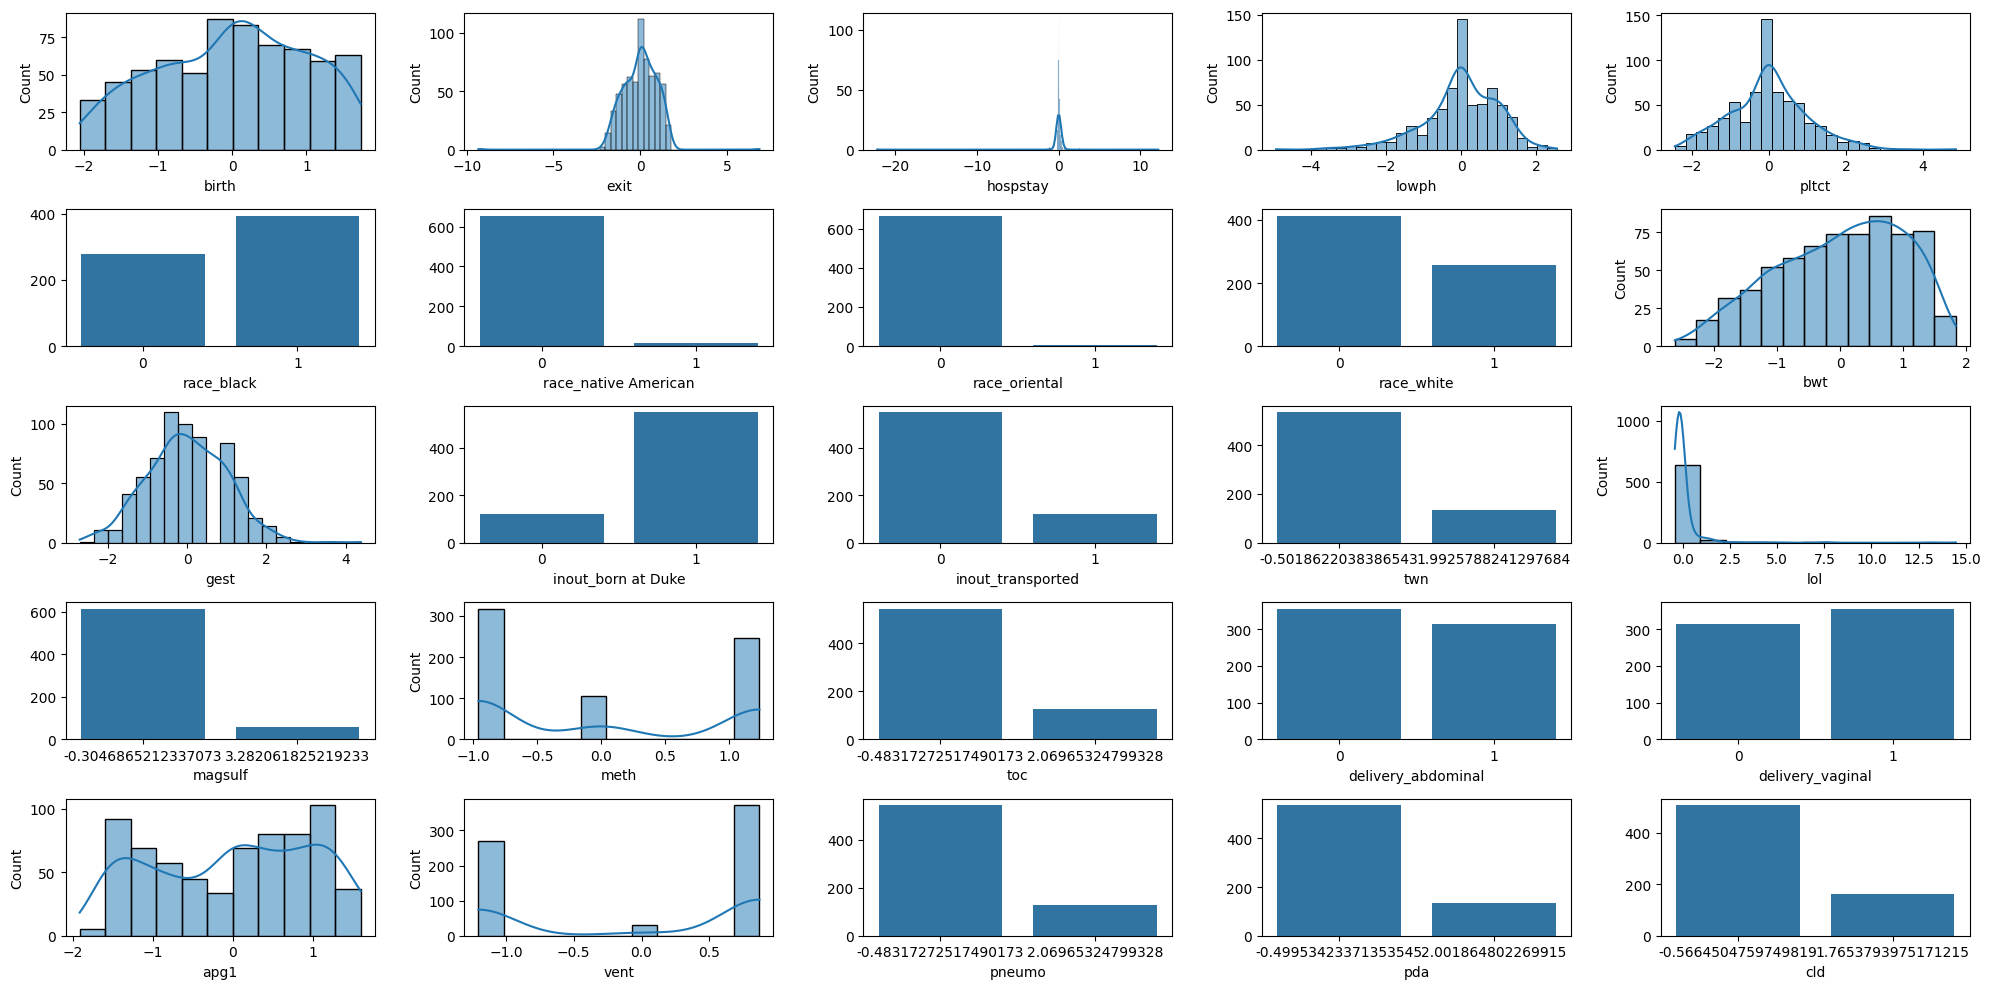


1. 변수 분포 및 스케링 확인 
 표준화 형태로 전처리 되어, 모델에 적합한 스케일로 변환되었음을 알 수 있다. birth, pltct,gest와 같은 
 변수는 좌우로 약간의 왜도가 존재하지만 전체적으로 대칭적인 분포를 가지고 있어, 모델에 적합하게 이루어졌다. 

 lol, vent와 같은 경우에는 한 쪽으로 치우진 분포를 가지고 있으나, 데이터의 특징과 간염 수치에 대한 데이터라는
 점을 생각했을때 이상치라고 보기엔 어렵다. 

2. 상관계수 
  전체적으로 높은 상관관계를 가지는 변수들이 존재하진않고, year, exit과 brith, exit의 상관계수가 높기 때문에
  해석에 유의해야한다. 
 


In [164]:

fig, axes = plt.subplots(5,5, figsize = (20, 10))
for axes, col in zip(axes.flatten(), m_df.columns) :
  if m_df[col].nunique() == 2 :
    target= m_df[col].value_counts()
    sns.barplot(x = target.index, y = target.values, ax = axes)

  else :
    sns.histplot(m_df[col], kde = True, ax = axes)

plt.tight_layout()
plt.show()
print('''
1. 변수 분포 및 스케링 확인
 표준화 형태로 전처리 되어, 모델에 적합한 스케일로 변환되었음을 알 수 있다. birth, pltct,gest와 같은
 변수는 좌우로 약간의 왜도가 존재하지만 전체적으로 대칭적인 분포를 가지고 있어, 모델에 적합하게 이루어졌다.

 lol, vent와 같은 경우에는 한 쪽으로 치우진 분포를 가지고 있으나, 데이터의 특징과 간염 수치에 대한 데이터라는
 점을 생각했을때 이상치라고 보기엔 어렵다.

2. 상관계수
  전체적으로 높은 상관관계를 가지는 변수들이 존재하진않고, year, exit과 brith, exit의 상관계수가 높기 때문에
  해석에 유의해야한다.
 ''')

##### 1-5) 뇌출혈(bleed)를 예측하기 위한 단일 알고리즘 모델과 앙상블 모델 비교 (15점)
- 첫번째 학습모델 / dead ,pvh,ivh,ipe,id 제외 /
- bleed 종속변수
- bleed가 Null인 행 제외
- ind = 2 : train / ind= 0 : test / ind=1 : bleed 결측치

In [165]:
# Bleed가 Null인 행 제외 - 전처리에서 1인것들 제외
model_df = m_df[m_df['Ind'] != 1].reset_index(drop = True)

X = model_df.drop(columns = ['dead','Bleed'])
y = model_df['Bleed'].astype(int)

def eval_model(name, model) :
  x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
  model.fit(x_train, y_train)
  pred = model.predict(x_test)
  acc = accuracy_score(y_test, pred)
  f1 = f1_score(y_test, pred)

  return name, acc, f1

res = []
for name, model in [['LG', LogisticRegression()], ['RF', RandomForestClassifier()]] :
  name, acc, f1 = eval_model(name, model)
  res.append({
      'Model Name' : name,
      'Accuracy Score' : acc,
      'F1 score' : f1
  })

print(pd.DataFrame(res))
print('''
단일 알고리즘 모델로 로지스틱회귀, 앙상블 모델로는 랜덤포레스트트를 사용하고, 모델 성능 지표로는
Accuracy Score, F1 Score를 사용했다.

Accuracy Score는 랜덤 포레스트가 70%정도로 로지스틱 회귀보다 나은 성능을 보여준다.
F1 Score의 경우, 불균형한 클래스에 중요한 지표로서 0.447로 랜덤 포레스트가 좀 더 우수했다.
이는 재현과 정밀도의 측면에서 랜덤 포레스트가 더 나은 예측 성능을 보였음을 의미한다.

로지스틱 모델은 선형관계를 기반으로, 단순 선형관계가 있는 데이터에서 강점을 가지지만, 비선형적
관계에서는 변수간 상호작용을 잘 반영하지 못한다.

반면, 랜덤 포레스트는 다수의 결정 트리를 앙상블하여, 복잡한 패턴과 비선형적 관계를 효과적으로
학습할 수 있어, 구조가 복잡한 임상 데이터에서 우수한 성능을 보여준다.
''')

  Model Name  Accuracy Score  F1 score
0         LG        0.652778     0.375
1         RF        0.708333     0.475

단일 알고리즘 모델로 로지스틱회귀, 앙상블 모델로는 랜덤포레스트트를 사용하고, 모델 성능 지표로는
Accuracy Score, F1 Score를 사용했다. 

Accuracy Score는 랜덤 포레스트가 70%정도로 로지스틱 회귀보다 나은 성능을 보여준다.
F1 Score의 경우, 불균형한 클래스에 중요한 지표로서 0.447로 랜덤 포레스트가 좀 더 우수했다. 
이는 재현과 정밀도의 측면에서 랜덤 포레스트가 더 나은 예측 성능을 보였음을 의미한다. 

로지스틱 모델은 선형관계를 기반으로, 단순 선형관계가 있는 데이터에서 강점을 가지지만, 비선형적
관계에서는 변수간 상호작용을 잘 반영하지 못한다.

반면, 랜덤 포레스트는 다수의 결정 트리를 앙상블하여, 복잡한 패턴과 비선형적 관계를 효과적으로
학습할 수 있어, 구조가 복잡한 임상 데이터에서 우수한 성능을 보여준다.



##### 1-6) 사망여부(dead)를 예측하기 위한 기계학습 모델 (10점)
- 모델링과 해석은 6번과 동일 / pvh,ivh,ipe,id 제외
- 6번에서 생성한 데이터
- bleed : 독립
- train : ind (1,2번)  / test : ind(0번)

In [172]:
train_set = m_df[m_df['Ind'].isin([1,2])]
test_set =  m_df[m_df['Ind'] == 0]


x_train = train_set.drop(columns = 'dead', axis = 1)
y_train = train_set['dead']

x_test = test_set.drop(columns = 'dead', axis = 1)
y_test = test_set['dead']


def eval_model(name, model, x_train, y_train, x_test, y_test) :
  model.fit(x_train, y_train)
  pred = model.predict(x_test)
  acc = accuracy_score(y_test, pred)
  f1 = f1_score(y_test, pred)

  return name, acc, f1

res = []
for name, model in [['LG', LogisticRegression()], ['RF', RandomForestClassifier()]] :
  name, acc, f1 = eval_model(name, model, x_train, y_train, x_test, y_test)
  res.append({
      'Model Name' : name,
      'Accuracy Score' : acc,
      'F1 score' : f1
  })

print(pd.DataFrame(res))

  Model Name  Accuracy Score  F1 score
0         LG        0.763158  0.307692
1         RF        0.953947  0.588235


##### MANOVA
1. y가 두개 x가 1개 이상
- 종속변수들은 모두 연송형이며, 정규성을 만족해야함
- 등분산성 가정 (Box`s M test) 필요
- sex, method는 그룹 비교가능  
</br>
예) 성별과 교육방법이 학생의 성적, 발표 점수, 보고서 점수 모두에 어떤 영향을 미치는지를 동시에 분석하고 싶을 때 사용

In [174]:
df = pd.read_csv('https://raw.githubusercontent.com/doeungim/ADP_DE2/refs/heads/main/dataset/manova_score_data.csv')
df.head(10)

,sex,method,study_time,assignment_score,attendance,satisfaction,participation,score1,score2,score3
0,male,online,10.871752,78.344359,88.807910,2,1,41.947510,36.214346,58.005302
1,female,offline,9.362086,87.512905,88.730917,3,2,61.785674,44.237289,67.054027
2,male,offline,11.260976,66.059436,88.377935,2,3,42.619120,47.749478,52.964422
3,male,offline,5.695013,72.063968,90.693052,1,1,40.110709,46.972875,57.259553
4,male,offline,7.069768,79.381556,87.923842,0,3,41.233381,41.921778,53.635150
5,male,online,10.726891,84.440973,90.404910,1,2,39.647668,43.983702,62.444578
6,male,offline,13.725855,79.651885,98.299809,0,2,47.251163,50.129463,55.390170
7,female,offline,11.670117,79.521736,89.839172,1,3,50.214910,49.287737,62.264708
8,female,offline,8.635098,79.391293,88.697986,3,3,55.435189,42.547886,62.219681
9,male,offline,6.615895,71.185511,84.996932,3,2,39.334637,38.841747,55.031220


In [185]:
#!pip install pingouin
import pingouin as pg

df['sex_method'] = df[['sex', 'method']].apply(lambda x: f"{x[0]}_{x[1]}", axis=1)
pg.box_m(data=df, dvs=['score1', 'score2', 'score3'], group='sex_method')

/tmp/ipython-input-185-1995633067.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df['sex_method'] = df[['sex', 'method']].apply(lambda x: f"{x[0]}_{x[1]}", axis=1)


,Chi2,df,pval,equal_cov
box,10.738342,18.0,0.905129,True


In [176]:
from statsmodels.multivariate.manova import MANOVA

model = MANOVA.from_formula('score1 + score2 + score3 ~ sex * method', data = df)
print(model.mv_test())

                   Multivariate linear model
                                                                
----------------------------------------------------------------
       Intercept         Value  Num DF  Den DF   F Value  Pr > F
----------------------------------------------------------------
          Wilks' lambda  0.0102 3.0000 294.0000 9483.5730 0.0000
         Pillai's trace  0.9898 3.0000 294.0000 9483.5730 0.0000
 Hotelling-Lawley trace 96.7712 3.0000 294.0000 9483.5730 0.0000
    Roy's greatest root 96.7712 3.0000 294.0000 9483.5730 0.0000
----------------------------------------------------------------
                                                                
----------------------------------------------------------------
             sex           Value  Num DF  Den DF  F Value Pr > F
----------------------------------------------------------------
             Wilks' lambda 0.5936 3.0000 294.0000 67.0885 0.0000
            Pillai's trace 0.4064 3.0000 294.

In [177]:
# 2. score ~ sex가 유의하다면, t-test 혹은 pairwise_tukeyhsd 를 통해 사후검정을 수행
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

model = ols('score1 ~ sex' , data = df).fit()
anova_lm(model)

pairwise_tukeyhsd(df['score1'], df['sex'])